<a href="https://colab.research.google.com/github/tekliyetamiru/Fine-Tuning-BERT-for-Multi-Class-Sentiment-Classification-for-Twitter-Tweets/blob/main/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers**

In [ ]:
!pip install -U transformers
!pip install -U accelerates
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [ ]:
!pip install -U pyarrow datasets pandas

## **Loading Data from Github**

In [6]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv")
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [3]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [7]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [ ]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


# Tokenization

In [8]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, stratify = df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])
train.shape, test.shape, validation.shape

((11200, 3), (3200, 3), (1600, 3))

In [10]:
from datasets import Dataset, DatasetDict

dataset=DatasetDict(
    {
    'train':Dataset.from_pandas(train,preserve_index=False),
    'test':Dataset.from_pandas(test,preserve_index=False),
    'validation':Dataset.from_pandas(validation,preserve_index=False)
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 1600
    })
})

In [9]:
dataset['train'][0]

{'text': 'i feel like i am as fearful now as i was when i first threw my leg over the top tube after my surgery',
 'label': 4,
 'label_name': 'fear'}

In [11]:
def tokenize(batch):
  temp = tokenizer(batch['text'],padding=True, truncation=True)
  return temp

tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2514, 2428, 6919, 2007, 2010, 24618, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2102, 2393, 2021, 2514, 2008, 2065, 1045, 2910, 2102, 2018, 2042, 2061, 14337, 2059, 1045, 2071, 2031, 18304, 2017, 2013, 3110, 2023, 2126, 2085, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [12]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [13]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'joy': 1, 'anger': 3, 'sadness': 0, 'fear': 4, 'surprise': 5, 'love': 2},
 {1: 'joy', 3: 'anger', 0: 'sadness', 4: 'fear', 5: 'surprise', 2: 'love'})

## **Model Building**

In [14]:
from transformers import AutoModel
import torch

In [15]:
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.6",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [18]:
from transformers import AutoModelForSequenceClassification,AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Building Training Arguments**

In [17]:
from transformers import TrainingArguments

batch_size = 64
traing_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir = traing_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = "epoch",
    disable_tqdm = False
)

### **Build compute metrics functions**

In [19]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00


In [20]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return accuracy.compute(predictions=predictions, references=labels)

In [21]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds,average="weighted")
  acc = accuracy_score(labels,preds)

  return {"accuracy":acc, "f1":f1}

### **Building Model and Trainer**

In [22]:
from transformers import Trainer

trainer = Trainer(model=model,args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded["train"],
                  eval_dataset = emotion_encoded["validation"],
                  tokenizer = tokenizer)

/tmp/ipython-input-2237146537.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,args=training_args,


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,No log,0.469917,0.008700,0.848125,0.834188
2,No log,0.274437,0.008700,0.910625,0.909509


TrainOutput(global_step=350, training_loss=0.6944698660714286, metrics={'train_runtime': 352.4979, 'train_samples_per_second': 63.546, 'train_steps_per_second': 0.993, 'total_flos': 1001502421516800.0, 'train_loss': 0.6944698660714286, 'epoch': 2.0})

### **Evaluate Model**

In [31]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.29179608821868896,
 'test_model_preparation_time': 0.0087,
 'test_accuracy': 0.9021875,
 'test_f1': 0.9021342382488037,
 'test_runtime': 11.6857,
 'test_samples_per_second': 273.839,
 'test_steps_per_second': 4.279}

In [33]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       933
           1       0.94      0.92      0.93      1072
           2       0.78      0.83      0.80       261
           3       0.89      0.91      0.90       432
           4       0.84      0.90      0.87       387
           5       0.87      0.68      0.76       115

    accuracy                           0.90      3200
   macro avg       0.87      0.86      0.87      3200
weighted avg       0.90      0.90      0.90      3200



### **Plot Confusion Matrix**

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

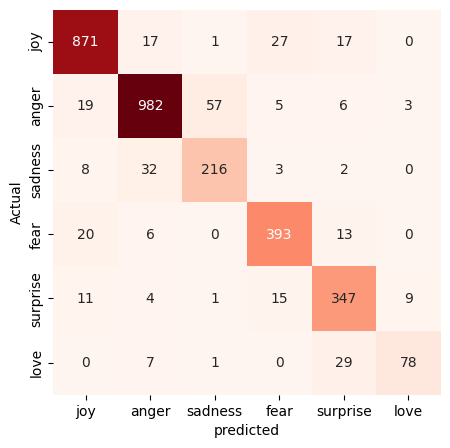

In [36]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True, xticklabels=label2id.keys(),yticklabels=label2id.keys(),fmt='d',cbar=False,cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("predicted")
plt.show()

### **Build Prediction Function and Store Model**

In [37]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
  input_encoded = tokenizer(text,return_tensors='pt').to(device)

  with torch.no_grad():
    outputs = model(**input_encoded)

  logits = outputs.logits
  pred = torch.argmax(logits, dim=1).item()
  return id2label[pred]

In [38]:
get_prediction(text)

'joy'

In [39]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [40]:
# Use pipeline for prediction
from transformers import pipeline

classifier = pipeline("text-classification",model = 'bert-base-uncased-sentiment-model')

classifier([text,'hello, how are you?',"I love you","i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9550183415412903},
 {'label': 'joy', 'score': 0.6873904466629028},
 {'label': 'love', 'score': 0.6227322816848755},
 {'label': 'sadness', 'score': 0.9671816229820251}]

### **Build Streamlit Application and Model**

In [43]:
%%writefile app.py
import streamlit as st
import pandas as pd
from transformers import pipeline

st.title("BERT Twitter Sentiment Analysis")
st.subheader("Multi-Class Classification")

text_input = st.text_input("Enter a tweet:")
if text_input:
    # This is a placeholder; replace 'sentiment-analysis' with your specific fine-tuned model path later
    classifier = pipeline("sentiment-analysis")
    result = classifier(text_input)
    st.write(result)

Writing app.py


In [49]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.6 MB/s eta 0:00:00


In [1]:
!curl ipv4.icanhazip.com

34.16.173.1


In [2]:
!streamlit run app.py & npx localtunnel --port 8501

/bin/bash: line 1: streamlit: command not found
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦your url is: https://tiny-showers-mate.loca.lt
34.16.173.1
^C
